# Data Science Take Home Challenge

1. There are several steps to deal with this problem.
    1. Data exploration. Using correlation matrix, heatmap, and histogram etc. to explore data distribution and characteristics.
    2. Feature engineering and selection. This step includes creating new features, dealing with outliers, getting one-hot or dummy encoding for categorical features, filling up null values and normalizing data. Some useless features or too noisy features should be dropped.
    3. Model training and evaluation. GBDT performs better than other classifiers such as logistic regression, random forest or svm. In order to get a stable result, a 5-fold cross validation is used. Ensemble is not used here due to a laptop.
    
2. The baseline model is just random guess. 
  The theoretical accuracy of random guess for two-classification problem is P(c=0)\*P(you guess 0)+P(c=1)\*P(you guess 1). The numbers of positive and negative samples are 60510 and 123769, so the percentages are 0.3284 and 0.6716. So the accuracy for random guess is 0.3284^2 + 0.6716^2 = 0.559. 
  Finally using a single GBDT classifier has an average accuracy of 0.852, increasing by 30 percent. Also, the precision is 0.802. There is still room for imporving it, such as generating new features by correlated features, grid search for hyper parameters and ensemble. 

3. The loss function is binomial deviance, just like logloss in logistic regession. There are several mertrics to evaluate this model, such precision, recall, f1, accuracy or auc. I think the precision is more important. If using these predicted results to recommend listings to a user, it may result in a higher booking rate if the listing is more relevent to the user. The user do not care about the overall listings he is really interested in.

4. This model can be used to recommend items for users. 
  1. First, retrieve candidates from the whole listing database for the user. Content-based filtering and collaborative filtering can be applied to calculating closest listings or users. Collaborative filtering utilizes interaction behaviors, such as clicks or ratings, to find closest neighbors for each listing and user. 
  In this challenge, the location of listings is not helpful for predicting. I think the reason might be that users have been to these three cities. On the other hand, he or she usually go to cities already in mind and then pick up accommodations. So, we can filter listings by cities that the user has been to and similar cities according to distance and climate, etc..
  2. Second, rank the candidates retrieved. The model can be used in this step to suggest top k listings with largest probabilities. However, if the user is new here, it is difficult to know his or her preferance, namly cold start.
  3. Finally, recommendation can be combined from various strategies, such as content-based, model ranking, freshness and popularity.
  
5. Other prediction problems. One problem I can think of is predicting the listing price according to the demand and listing attributes. It can maximize profit of landlord and the platform.


## 1. Data loading

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from datetime import datetime, timedelta

import xgboost
import lightgbm
from scipy.stats import norm, skew, mode
from scipy.stats import pearsonr, spearmanr
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA, KernelPCA
from mpl_toolkits.mplot3d import axes3d, Axes3D #3D plot
from sklearn.manifold import TSNE
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.linear_model import BayesianRidge, LogisticRegression
from sklearn.linear_model import TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, SVR
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

sns.set_style('whitegrid',{'font.sans-serif':['simhei','Arial']})

# Load data
data = pd.read_csv('data_total.tsv', sep='\t')

## 2. Data exploration

In [2]:
# Data statistics
print('Total data shape:', data.shape)
print('Unique listing:', data['id_listing_anon'].unique().shape)
print('Unique user:', data['id_user_anon'].unique().shape)
print('Postive samples:', data['dim_is_requested'].sum())
print('Negative samples:', len(data)-data['dim_is_requested'].sum())
dataset = data.copy()

Total data shape: (184279, 46)
Unique listing: (10442,)
Unique user: (7936,)
Postive samples: 60510
Negative samples: 123769


In [3]:
dataset.head()

,dim_is_requested,ds_night,ds,id_listing_anon,id_user_anon,m_effective_daily_price,m_pricing_cleaning_fee,dim_market,dim_lat,dim_lng,...,general_market_m_reservation_requests_0_6_ds_night,general_market_m_is_booked_0_6_ds_night,m_available_listings_ds_night,kdt_score,r_kdt_listing_views_0_6_avg_n100,r_kdt_n_active_n100,r_kdt_n_available_n100,r_kdt_m_effective_daily_price_n100_p50,r_kdt_m_effective_daily_price_available_n100_p50,r_kdt_m_effective_daily_price_booked_n100_p50
0,False,2015-01-06,2014-12-07,0ae0c7cc-a8a4-425f-9ccc-8b25dbb94f4d,dcc74708-d5c4-47b2-bc0c-97bf5abfcd99,110.000000,60.0,Los Angeles,34.053932,-118.362970,...,41.428571,1.0,9840,1.314286,1.795918,57.0,48.0,79.0,75.0,98.0
1,True,2015-01-21,2014-12-22,82fdda07-6993-4cca-8ee4-fc218d2c07c7,559d8981-0c75-4631-9582-a3b644bb5631,70.000000,0.0,Los Angeles,34.108578,-118.208600,...,51.714286,1.0,9599,0.535714,2.693878,49.0,36.0,65.0,65.0,42.0
2,False,2015-01-22,2014-12-23,69b2069d-cf8f-49a7-b559-9619dbe86a7d,ee7901a6-79d5-4d69-bacf-e4bca976a66a,125.000000,0.0,Los Angeles,34.077194,-118.205700,...,51.714286,1.0,9514,0.714286,2.775510,49.0,35.0,65.0,66.5,46.0
3,True,2015-02-02,2015-01-03,66baade6-9352-4d7c-b590-745899bd12b3,af691f3d-525e-497c-b9c5-8750b097b04d,126.866667,125.0,Los Angeles,34.093494,-118.247340,...,41.857143,1.0,9739,1.744681,4.576531,113.0,52.0,120.0,115.0,115.0
4,True,2015-02-13,2015-01-14,01e3589e-a50a-494b-8cb2-9645b29476d0,6733a1d9-d485-4ea7-b8d2-883ee8a363b9,210.714286,200.0,Los Angeles,34.097540,-118.363556,...,78.857143,1.0,9114,1.200000,4.877551,97.0,57.0,150.0,157.5,164.5


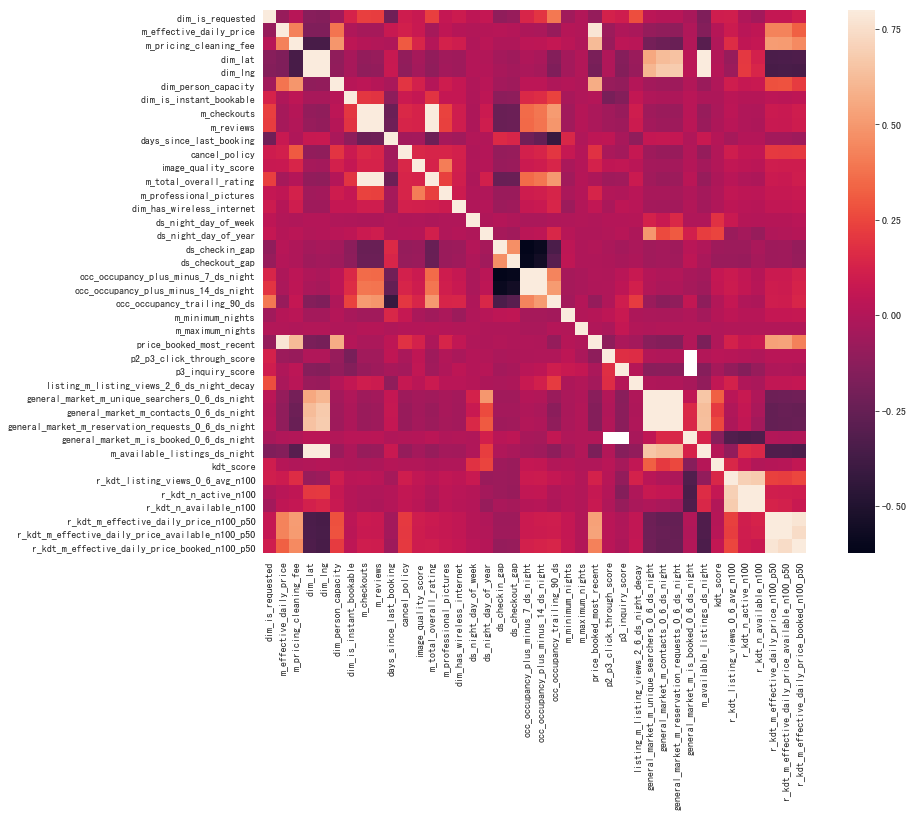

In [4]:
# Heatmap of correlation matrix
'''
The correlation matrix shows covariances between each two features.
1. There are several white squares, ie. 'dim_lat' and 'dim_lng', 'm_checkouts' and 'm_reviews', 
  'occ_occupancy_plus_minus_{day}_ds_night', 'general_market_m_{type}_0_6_ds_night',
  'r_kdt_n_{status}_n100'. The correlation is so strong which indicates a situation of 
  multicollinearity. So some of theres columns can be abandoned to reduce computation.
2. The goal is to predict whether the listing will be booked. There is no white region between 
  the target 'dim_is_requested' and any of other features. So most of these features may contain 
  some userful information to predict.
'''
corrmat = data.corr()
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

In [5]:
# Topk related features
'''
1. Most of these features have relatively more important which can be checked by the average depth 
  using GBDT.
'''
k = 10
related_cols = corrmat.apply(abs).nlargest(k, 'dim_is_requested')['dim_is_requested'].index
print('Most related features:\n', corrmat['dim_is_requested'][related_cols])

Most related features:
 dim_is_requested                              1.000000
occ_occupancy_trailing_90_ds                  0.397357
listing_m_listing_views_2_6_ds_night_decay    0.274125
m_checkouts                                   0.231641
m_total_overall_rating                        0.229227
m_reviews                                     0.225445
days_since_last_booking                      -0.215444
occ_occupancy_plus_minus_14_ds_night          0.196271
m_available_listings_ds_night                -0.165552
dim_lng                                      -0.147375
Name: dim_is_requested, dtype: float64


In [6]:
# Scatter plot for most related features
'''
1. Some features are linearly dependent, such as 'm_checkouts' and 'm_reviews'. Hence one of them 
  can be discarded.
2. Although 'p2_p3_click_through_score' is highly relevent, it contains too much null values shown 
  in the following part. So it should be descarded too.
3. 'occ_occupancy_trailing_90_ds' is highly relevent to the target. We can dig into these important 
  features which may help generate userful features grouped by listing id.
'''
# sns.set()
# cols = related_cols.values
# sns.pairplot(data[cols].astype(np.float32), height=3)
# plt.show()

"\n1. Some features are linearly dependent, such as 'm_checkouts' and 'm_reviews'. Hence one of them \n  can be discarded.\n2. Although 'p2_p3_click_through_score' is highly relevent, it contains too much null values shown \n  in the following part. So it should be descarded too.\n3. 'occ_occupancy_trailing_90_ds' is highly relevent to the target. We can dig into these important \n  features which may help generate userful features grouped by listing id.\n"

In [7]:
# Missing data
'''
1. There are some features most of which are null, like 'p3_inquiry_score', 'p2_p3_click_through_score'.
  Although 'p2_p3_click_through_score' is highly correlated to the target, it should be abandoned.
2. 'days_since_last_booking' and 'price_booked_most_recent' still have nearly 20 percent null values, 
  but there highly correlated to the target. Also, they can used to derived good features that prove to
  have good performance in training models.
3. The other features are all kept.
'''
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print(missing_data.head(25))

                                                   Total   Percent
p3_inquiry_score                                  129290  0.701599
p2_p3_click_through_score                         127110  0.689769
days_since_last_booking                            37836  0.205319
price_booked_most_recent                           37836  0.205319
occ_occupancy_plus_minus_7_ds_night                20727  0.112476
occ_occupancy_plus_minus_14_ds_night               20652  0.112069
image_quality_score                                14011  0.076031
r_kdt_m_effective_daily_price_booked_n100_p50      12975  0.070410
occ_occupancy_trailing_90_ds                       10218  0.055449
listing_m_listing_views_2_6_ds_night_decay          2346  0.012731
ds_checkin_gap                                      2221  0.012052
ds_checkout_gap                                     2221  0.012052
m_maximum_nights                                    2221  0.012052
m_minimum_nights                                    2221  0.01

In [8]:
def log(y, reverse=False):
    '''
    负数砍掉
    '''
    y = np.array(y)
    if reverse:
        return np.expm1(y)
    is_neg = np.where(y<0)
    y[is_neg] = -y[is_neg] #负的取正
    y = np.log1p(y) #不会出现底部0的情况，左加右减，左+1过零点
    y[is_neg] = -y[is_neg]
    return y

def plot(x, y=None, mode=None, bins=None, title=None, xlabel=None, ylabel=None, image_path=None):
    fig, ax = plt.subplots(figsize=(6,4))
    if mode == 'bar':
        #不连续
        assert y is not None, 'Args `y` must be provided!'
        ax.bar(x, y, width=0.3)
    elif mode == 'hist':
        #连续
        assert bins is not None, 'Args `bins` must be provided!'
        ax.hist(x, bins=bins)
    else:
        raise ValueError('Unsupported mode!')
    ax.set(title=title, xlabel=xlabel, ylabel=ylabel)
    if image_path:
        plt.savefig(image_path, transparent=False)
    plt.show()
#fit_reg True:拟合
def scatter_plot(col1, col2, df, fn=None, outlier=None, fit_reg=False, image_path=None):
    '''
    col1,col2: two column names
    df: pandas dataframe
    fn: transform function
    outlier: params to show outliers, should be [col_name, threshold]
    fit_reg: whether to show regresstion line
    '''
    df_ = df.copy()
    if fn is not None:
        df_[col1], df_[col2] = fn(df[col1]), fn(df[col2])
    if not fit_reg:
        fig, ax = plt.subplots(figsize=(6,6))
        ax.scatter(df_[col1], df_[col2])
        ax.set(title='Scatter plot', xlabel=col1, ylabel=col2)
    else:
        sns.lmplot(x=col1, y=col2, data=df_, fit_reg=True, height=6, aspect=1.6)
    if outlier and col1 == outlier[0]:
        plt.axvline(outlier[1], color='red')
    elif outlier:
        plt.axhline(outlier[1], color='red')
    if image_path:
        plt.savefig(image_path, transparent=False)
    plt.show()

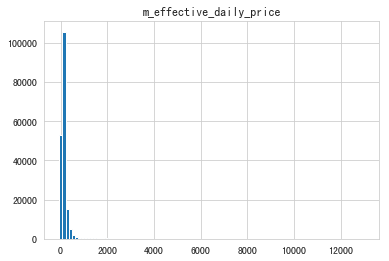

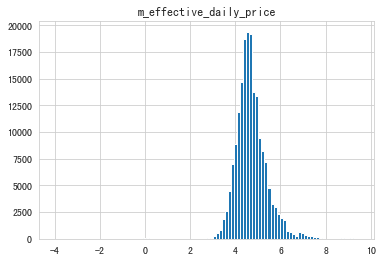

(-0.08995795688321503, 0.0)
(-0.168942267594816, 0.0)


In [9]:
# Night
col = 'm_effective_daily_price'
plot(dataset[col], mode='hist', title=col, bins=100)
plot(log(dataset[col]), mode='hist', title=col, bins=100)
print(pearsonr(dataset[col], dataset['dim_is_requested']))  # pvalue越小，相关性越弱
print(pearsonr(log(dataset[col]), dataset['dim_is_requested']))

/home/edili/venv/lib/python3.5/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/edili/venv/lib/python3.5/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


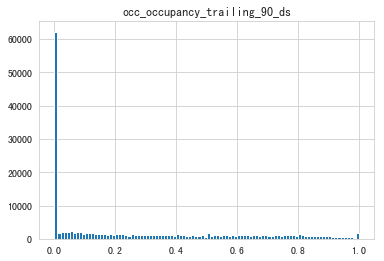

/home/edili/venv/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


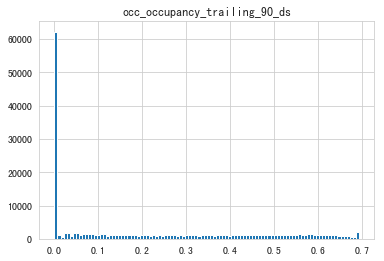

In [10]:
col = 'occ_occupancy_trailing_90_ds'
#这种是稀疏数据，一半是0，一半有数据
plot(dataset[col], mode='hist', title=col, bins=100)
plot(log(dataset[col]), mode='hist', title=col, bins=100)

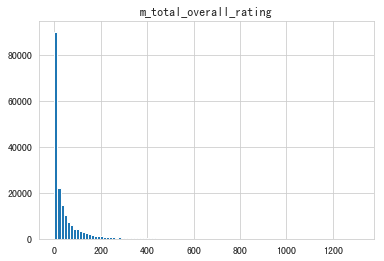

In [11]:
# Listing
#normalize也没有什么影响
col = 'm_total_overall_rating'
plot(dataset[col], mode='hist', title=col, bins=100)

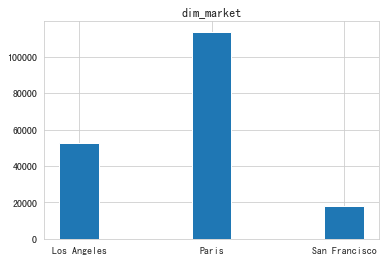

In [12]:
col = 'dim_market'
#衍生特征，某个地区偏好
x = dataset[col].value_counts().sort_index()
x,y = x.index,x.values
plot(x, y, mode='bar', title=col)

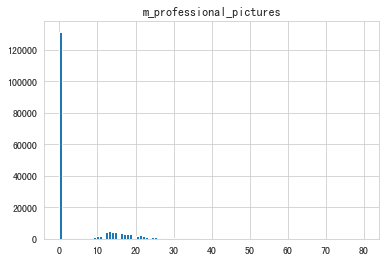

In [13]:
col = 'm_professional_pictures'
#稀疏·
plot(dataset[col], mode='hist', title=col, bins=100)

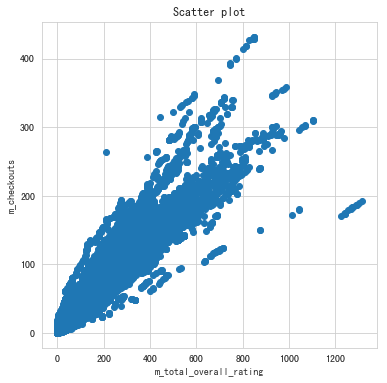

In [14]:
col1 = 'm_total_overall_rating'
col2 = 'm_checkouts'
#二者有相关性·都可以保留起来
scatter_plot(col1, col2, dataset)

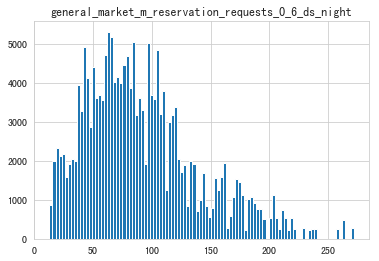

In [15]:
col = 'general_market_m_reservation_requests_0_6_ds_night'
#不转化成正态分布也是可以的
plot(dataset[col], mode='hist', title=col, bins=100)

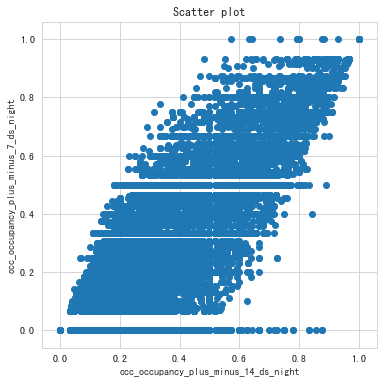

In [16]:
col1 = 'occ_occupancy_plus_minus_14_ds_night'
col2 = 'occ_occupancy_plus_minus_7_ds_night'
#留下7天，因为7天影响14天的区间
scatter_plot(col1, col2, dataset)

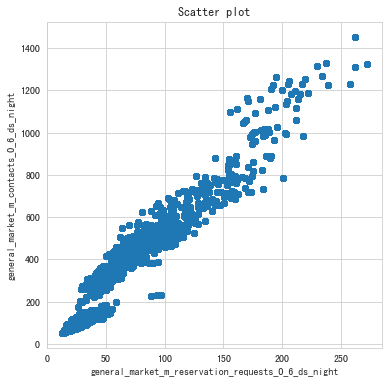

In [17]:
col1 = 'general_market_m_reservation_requests_0_6_ds_night'
col2 = 'general_market_m_contacts_0_6_ds_night'
#留一个就可以了
#试一下决定留哪个更好
scatter_plot(col1, col2, dataset)

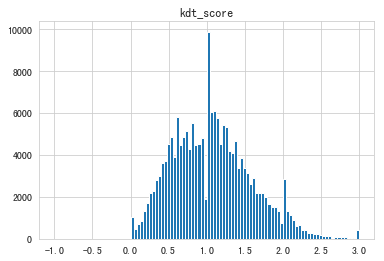

In [18]:
col = 'kdt_score'
#比较正太
plot(dataset[col], mode='hist', title=col, bins=100)

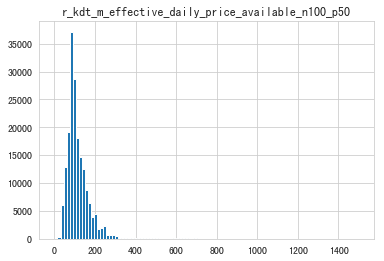

In [19]:
col = 'r_kdt_m_effective_daily_price_available_n100_p50'
#log不log都可以
plot(dataset[col], mode='hist', title=col, bins=100)

## 3. Feature engineering and selection

In [20]:
# Add month feature by date

date_to_month_fn = lambda d: int(datetime.strptime(d, '%Y-%m-%d').strftime('%-m'))
date_to_workday_fn = lambda d: 0 if datetime.strptime(d, '%Y-%m-%d').strftime('%w') in ['0','5','6'] else 1

# dataset['ds_night_month_of_year'] = dataset['ds_night'].apply(date_to_month_fn)
# dataset['ds_night_workday'] = dataset['ds_night'].apply(date_to_workday_fn)

In [21]:
# Convert listing and user id to int
label_encoder = LabelEncoder()

listing_user_cols = ['id_listing_anon', 'id_user_anon', 'dim_market', 'dim_room_type']
for col in listing_user_cols:
    dataset[col] = label_encoder.fit_transform(dataset[col].values)

In [22]:
# Calculate mean values of each listing id
#衍生特征
mean_values_cols = ['m_effective_daily_price', 'm_pricing_cleaning_fee', 
                    'price_booked_most_recent', 'occ_occupancy_plus_minus_14_ds_night', 
                    'occ_occupancy_trailing_90_ds', 'occ_occupancy_plus_minus_7_ds_night', 
                    'listing_m_listing_views_2_6_ds_night_decay']
mean_values_by_listing = dataset[['id_listing_anon'] + mean_values_cols].groupby(by='id_listing_anon').mean()

for col in mean_values_cols:
    id_listing_mean = mean_values_by_listing[col].to_dict()
    dataset[col+'_by_listing'] = dataset['id_listing_anon'].apply(lambda x: id_listing_mean[x])

In [23]:
# Calculate mean values of each user id
#衍生特征
mean_values_cols = ['m_effective_daily_price', 'm_reviews', 'days_since_last_booking', 
                    'm_total_overall_rating']
mean_values_by_user = dataset[['id_user_anon'] + mean_values_cols].groupby(by='id_user_anon').mean()

for col in mean_values_cols:
    id_user_mean = mean_values_by_user[col].to_dict()
    dataset[col+'_by_user'] = dataset['id_user_anon'].apply(lambda x: id_user_mean[x])

In [24]:
# Get dummy features by user id
dummy_feat = ['dim_market', 'dim_room_type']

for feat in dummy_feat:
    feat_dummies = pd.get_dummies(dataset[feat])
    feat_dummies.columns = ['%s_%s_by_user'%(feat.split('_')[-1], col) for col in feat_dummies.columns]
    feat_dummies['id_user_anon'] = dataset['id_user_anon'].values
    feat_dummies = feat_dummies.groupby('id_user_anon').sum()
    dataset = dataset.merge(feat_dummies, on='id_user_anon', how='left')

In [25]:
# svd features
'''
The value of interaction matrix is 1 if user has booked listing else 0. Do matrix decomposition and get
dense representation of user and listing.
The main topics are added as additional features, but it does not help increase model precision. I guess the 
samples are too small.
'''
from scipy import sparse
from scipy.sparse.linalg import svds

n_component = 5

listing_cnt = dataset['id_listing_anon'].max() + 1
user_cnt = dataset['id_user_anon'].max() + 1

# listing_user_rating = np.ones(len(dataset))
listing_user_rating = (dataset['dim_is_requested'] == True).astype(np.int).values

listing_id = dataset['id_listing_anon'].values
user_id = dataset['id_user_anon'].values

rating = sparse.coo_matrix((listing_user_rating, (user_id, listing_id)))
rating = (rating > 0) * 1.0

[u, s, vt] = svds(rating, k=n_component)
s_listing = np.diag(s[::-1])

user_topics = pd.DataFrame(u[:, ::-1])
user_topics.columns = ['user_component_%d'%i for i in range(n_component)]
user_topics['id_user_anon'] = range(user_cnt)
dataset = dataset.merge(user_topics, on='id_user_anon', how='left') # increase by 0.003

In [26]:
# Fill null values
total = dataset.isnull().sum().sort_values(ascending=False)
percent = (dataset.isnull().sum()/dataset.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_cols = missing_data[missing_data['Total'] > 0].index

imputer = SimpleImputer(strategy='median')  #'mean','median','most_frequent'  
for col in missing_cols[:5]:
    if col in ['p2_p3_click_through_score', 'p3_inquiry_score']: 
        continue
    dataset[col] = imputer.fit_transform(dataset[[col]])

col = 'p3_inquiry_score'
dataset[col] = dataset[col].map(lambda x: 0 if pd.isnull(x) else 1)
col = 'p2_p3_click_through_score'
dataset[col] = dataset[col].map(lambda x: 0 if pd.isnull(x) else 1)
# pearsonr(a, dataset['dim_is_requested'])

In [27]:
# Normalize data
normalizer = StandardScaler()

cols_to_scale_no_na = []#['m_effective_daily_price', 'm_pricing_cleaning_fee']
cols_to_scale_na = []#'m_checkouts', 'm_reviews', 'days_since_last_booking', 'm_total_overall_rating',
                 #'listing_m_listing_views_2_6_ds_night_decay', 'r_kdt_listing_views_0_6_avg_n100', 
                 #'r_kdt_n_active_n100', 'r_kdt_m_effective_daily_price_n100_p50',
                 #'r_kdt_n_available_n100', 'r_kdt_m_effective_daily_price_available_n100_p50']
for col in cols_to_scale_no_na+cols_to_scale_na:
    dataset[[col]] = normalizer.fit_transform(dataset[[col]])
    
cols = ['m_minimum_nights', 'm_maximum_nights', 'price_booked_most_recent', 
        'm_effective_daily_price', 'm_pricing_cleaning_fee', 'm_effective_daily_price_by_listing',
        'm_effective_daily_price_by_user']
for col in cols:
    dataset[col] = log(dataset[col])

/home/edili/venv/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


In [28]:
# Convert boolean features to 0/1
boolean_cols = ['dim_is_requested', 'dim_is_instant_bookable']
for col in boolean_cols:
    dataset[col] = dataset[col].astype(np.int)

In [29]:
'''
1. dim_has_wireless_internet没有什么影响
2. ds_night_day_of_week影响不大
3. p3_inquiry_score, p2_p3_click_through_score太稀疏
'''
# night
cols = ['m_effective_daily_price', 'm_pricing_cleaning_fee']
# listing
cols += ['dim_person_capacity', 'cancel_policy', #'m_reviews', dim_is_instant_bookable,
         'days_since_last_booking', 'image_quality_score', 'm_total_overall_rating',
         'm_professional_pictures']
# occuopacy/availability
cols += ['ds_night_day_of_week', 'ds_night_day_of_year',
         'ds_checkin_gap', 'ds_checkout_gap', #'occ_occupancy_plus_minus_14_ds_night',
         'occ_occupancy_trailing_90_ds', 'm_minimum_nights', 'm_maximum_nights']
# listing demand
cols += ['price_booked_most_recent',
         'listing_m_listing_views_2_6_ds_night_decay', 'm_checkouts']
# market demand
#从真正意义上讲，就考虑到以后，虽然对现在没有影响
cols += ['general_market_m_reservation_requests_0_6_ds_night',
         'general_market_m_is_booked_0_6_ds_night', 'm_available_listings_ds_night']
# kdt
cols += ['kdt_score', 'r_kdt_listing_views_0_6_avg_n100', 'r_kdt_n_active_n100',
         'r_kdt_n_available_n100', 'r_kdt_m_effective_daily_price_n100_p50',
         'r_kdt_m_effective_daily_price_available_n100_p50',
         'r_kdt_m_effective_daily_price_booked_n100_p50' ]
# additional features
cols += ['m_effective_daily_price_by_listing', 'm_pricing_cleaning_fee_by_listing',
         'price_booked_most_recent_by_listing', 'occ_occupancy_plus_minus_14_ds_night_by_listing',
         'occ_occupancy_trailing_90_ds_by_listing',
         'occ_occupancy_plus_minus_7_ds_night_by_listing',
         'listing_m_listing_views_2_6_ds_night_decay_by_listing',
         'm_effective_daily_price_by_user',
         'market_0_by_user', 'market_1_by_user',
         'market_2_by_user', 'type_0_by_user',
         'type_1_by_user', 'type_2_by_user']

cols += ['user_component_0', 'user_component_1', 'user_component_2',
        'user_component_3', 'user_component_4']

# Get training and label data
Y = dataset['dim_is_requested']
X = dataset[cols]

## 4. Model Training and evaluation

In [30]:
## Models
lr = LogisticRegression(solver='liblinear', #‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’
                        random_state=42)

ext = ExtraTreesClassifier(n_estimators=200, criterion='gini',
                           min_samples_split=30, min_samples_leaf=15, 
                           max_depth=6, max_features='sqrt', 
                           random_state=42, n_jobs=4)

gbdt = GradientBoostingClassifier(n_estimators=200, learning_rate=0.2, 
                                  #min_samples_split=45, min_samples_leaf=25, 
                                  max_depth=6, max_features='sqrt', 
                                  subsample=0.8, random_state=42)

xgb = xgboost.XGBClassifier(max_depth=6, learning_rate=0.3, 
                            n_estimators=200, objective='binary:logistic', 
                            gamma=0.1, verbosity=0,
                            subsample=0.8,colsample_bytree=0.9,
                            random_state=42, nthread=4)

lgb = lightgbm.LGBMClassifier(max_depth=7, learning_rate=0.3, 
                             num_leaves=60, min_split_gain=0.001,
                             reg_alpha=0.001, 
                             n_estimators=450, min_child_samples=25, 
                             subsample=0.8, colsample_bytree=0.95, 
                             random_state=42, n_jobs=4)

In [31]:
# kfold cross validation
bst_acc = 0
total_acc = 0
bst_clf = None
bst_X_test, bst_Y_test = None, None
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
for k, (tr_idx, te_idx) in enumerate(k_fold.split(X)):
    X_train, X_test = X.loc[tr_idx, :], X.loc[te_idx, :]
    Y_train, Y_test = Y[tr_idx], Y[te_idx]
    clf = lgb.fit(X_train, Y_train)
    acc = clf.score(X_test, Y_test)
    total_acc += acc
    print('%d fold accuracy:'%(k+1), acc)
    if acc > bst_acc:
        bst_acc = acc
        bst_clf = clf
        bst_X_test, bst_Y_test = X_test.copy(), Y_test.copy()
    break

print('Training data shape:', X_train.shape)
print('Test data shape:', X_test.shape)
print('Average accuracy:', total_acc/5)

1 fold accuracy: 0.8870740177990015
Training data shape: (147423, 47)
Test data shape: (36856, 47)
Average accuracy: 0.1774148035598003


In [1502]:
# Evaluation metric
Y_pred = bst_clf.predict(bst_X_test)
acc = accuracy_score(bst_Y_test, Y_pred)
cfm = confusion_matrix(bst_Y_test, Y_pred)
print('Best accuracy:', acc)
print('Confusion matrix:\n', cfm)

clf_re = classification_report(bst_Y_test, Y_pred)
print('Classification report:\n', clf_re)

Best accuracy: 0.8871282830475363
Confusion matrix:
 [[22912  1850]
 [ 2310  9784]]
Classification report:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92     24762
           1       0.84      0.81      0.82     12094

    accuracy                           0.89     36856
   macro avg       0.87      0.87      0.87     36856
weighted avg       0.89      0.89      0.89     36856



In [1057]:
# Feature importance
coef = pd.Series(bst_clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print('Feature importance:\n', coef)

Feature importance:
 occ_occupancy_trailing_90_ds_by_listing                  0.169109
listing_m_listing_views_2_6_ds_night_decay               0.080316
listing_m_listing_views_2_6_ds_night_decay_by_listing    0.057175
m_effective_daily_price_by_listing                       0.040174
market_1_by_user                                         0.037789
m_effective_daily_price                                  0.030664
general_market_m_reservation_requests_0_6_ds_night       0.028074
ds_checkout_gap                                          0.026095
m_available_listings_ds_night                            0.024855
price_booked_most_recent_by_listing                      0.024206
general_market_m_is_booked_0_6_ds_night                  0.024122
type_1_by_user                                           0.022862
m_minimum_nights                                         0.022006
m_effective_daily_price_by_user                          0.019624
ds_checkin_gap                                         

In [1058]:
# Feature importance
coef = pd.Series(bst_clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print('Feature importance:\n', coef)

Feature importance:
 occ_occupancy_trailing_90_ds_by_listing                  0.169109
listing_m_listing_views_2_6_ds_night_decay               0.080316
listing_m_listing_views_2_6_ds_night_decay_by_listing    0.057175
m_effective_daily_price_by_listing                       0.040174
market_1_by_user                                         0.037789
m_effective_daily_price                                  0.030664
general_market_m_reservation_requests_0_6_ds_night       0.028074
ds_checkout_gap                                          0.026095
m_available_listings_ds_night                            0.024855
price_booked_most_recent_by_listing                      0.024206
general_market_m_is_booked_0_6_ds_night                  0.024122
type_1_by_user                                           0.022862
m_minimum_nights                                         0.022006
m_effective_daily_price_by_user                          0.019624
ds_checkin_gap                                         